## **Part A — Data preparation**

### 1. Setup and Load Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
plt.style.use("seaborn-v0_8")

In [2]:
# Load Datasets
sentiment_path = "fear_greed_index.csv"
trades_path = "historical_data.csv"
sentiment_df = pd.read_csv(sentiment_path)
trades_df = pd.read_csv(trades_path)

#### 1.1 Number of rows and columns in datasets

In [3]:
# Unpack into separate variables for Fear & Greed Index dataset
rows, cols = sentiment_df.shape
print(f"Number of rows in Fear & Greed Index dataset: {rows}")
print(f"Number of columns in Fear & Greed Index dataset: {cols}")

print(f"*"*40)
# Unpack into separate variables for historical dataset
num_rows = len(trades_df) 
num_cols = len(trades_df.columns)
print(f"Number of rows in Historical dataset: {num_rows}")
print(f"Number of columns in Historical dataset: {num_cols}")


Number of rows in Fear & Greed Index dataset: 2644
Number of columns in Fear & Greed Index dataset: 4
****************************************
Number of rows in Historical dataset: 211224
Number of columns in Historical dataset: 16


#### 1.2 Missing values and Duplicates

In [4]:
def missing_values_and_duplicates(df, dataset_name):
    """
    This function is used to find missing values and duplicates from datasets.
    Params:
            df           : dataframe
            dataset_name : Name of dataset
    Return: 
            Missing Values and duplicates
    """
    print(f"\n------ {dataset_name} Dataset Summary ------")
    print("Shape (rows, columns):", df.shape)
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\n Duplicate rows:", df.duplicated().sum())

missing_values_and_duplicates(sentiment_df, "Fear & Greed Index")
missing_values_and_duplicates(trades_df, "Trading / Historical Data")


------ Fear & Greed Index Dataset Summary ------
Shape (rows, columns): (2644, 4)

Missing values:
timestamp         0
value             0
classification    0
date              0
dtype: int64

 Duplicate rows: 0

------ Trading / Historical Data Dataset Summary ------
Shape (rows, columns): (211224, 16)

Missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

 Duplicate rows: 0


### 2. Converting timestamps and align the datasets by date.

#### Fear & Greed Dataset

In [5]:
# Convert date column object to datetime object
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
# Keep daily level 
sentiment_df['date'] = sentiment_df['date'].dt.date

#### Trades/Historical Dataset

In [6]:
# Convert timestamp column to datetime object
trades_df['Timestamp IST'] = pd.to_datetime(trades_df['Timestamp IST'], errors='coerce')
trades_df['date'] = trades_df['Timestamp IST'].dt.date

### 3. Creating the key metrics to analyze :
###### daily PnL per trader (or per account), win rate, average trade size, leverage distribution, number of trades per day, long/short ratio


#### 3.1 daily PnL per trader (or per account)

In [7]:
# Daily PnL per trader
daily_pnl = trades_df.groupby(['date', 'Trade ID'])['Closed PnL'].sum().reset_index()
print("------ Daily PnL per Trader ------")
print(daily_pnl)

------ Daily PnL per Trader ------
             date      Trade ID     Closed PnL
0      2023-01-05  0.000000e+00       0.000000
1      2023-05-12  2.340000e+14       0.000000
2      2023-05-12  2.580000e+14       0.000000
3      2023-05-12  2.830000e+14       0.000000
4      2023-05-12  2.920000e+14       0.000000
...           ...           ...            ...
43506  2025-12-04  1.090000e+15  135456.234258
43507  2025-12-04  1.100000e+15     325.438225
43508  2025-12-04  1.110000e+15     198.969257
43509  2025-12-04  1.120000e+15      87.123745
43510  2025-12-04  1.130000e+15       0.000000

[43511 rows x 3 columns]


#### 3.2 Win Rate and Average Trade Size

In [8]:
# Win Rate and Average Trade Size
total_trades = len(trades_df)
winning_trades = len(trades_df[trades_df['Closed PnL'] > 0])
win_rate = (winning_trades / total_trades) * 100
avg_trade_size = trades_df['Size USD'].mean()

print(f"\n------ Performance Metrics ------")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Average Trade Size: ${avg_trade_size:.2f}")


------ Performance Metrics ------
Win Rate: 41.13%
Average Trade Size: $5639.45


#### 3.3 Leverage Distribution

In [9]:
# Use absolute Size USD
trades_df["abs_size_usd"] = trades_df["Size USD"].abs()

# Create percentile-based bins
low_th = trades_df["abs_size_usd"].quantile(0.33)
high_th = trades_df["abs_size_usd"].quantile(0.66)

def leverage_bucket(row):
    if row["abs_size_usd"] <= low_th:
        return "Low"
    elif row["abs_size_usd"] <= high_th:
        return "Medium"
    else:
        return "High"

trades_df["Approx Leverage Bucket"] = trades_df.apply(leverage_bucket, axis=1)

In [10]:
# Using value_counts to show frequency of leverage usage
leverage_dist = trades_df['Approx Leverage Bucket'].value_counts(normalize=True) * 100
print("\n------ Leverage Distribution (%) ------")
print(leverage_dist)



------ Leverage Distribution (%) ------
Approx Leverage Bucket
High      33.999924
Low       33.002405
Medium    32.997671
Name: proportion, dtype: float64


#### 3.4 Number of trades per day

In [11]:
trades_per_day = trades_df.groupby('date').size()
print("\n------ Number of Trades per Day ------")
print(trades_per_day)


------ Number of Trades per Day ------
date
2023-01-05       3
2023-05-12       9
2024-01-01      18
2024-01-02       6
2024-01-03     137
              ... 
2025-11-04    1096
2025-12-01     602
2025-12-02    1031
2025-12-03    3968
2025-12-04    2109
Length: 188, dtype: int64


#### 3.5 Long/Short Ratio

In [12]:
long_short_counts = trades_df['Side'].value_counts()
long_short_ratio = long_short_counts['BUY'] / long_short_counts['SELL']
print("\n------ Long/Short Ratio ------")
print(f"Ratio: {long_short_ratio:.2f} (Longs per Short)")



------ Long/Short Ratio ------
Ratio: 0.95 (Longs per Short)


## **Part B — Analysis**

### 1. Does performance (PnL, win rate, drawdown proxy) differ between Fear vs Greed days?

#### 1.1 Build Daily Performance Metrics

In [13]:
# Daily trader-level performance
daily_perf = (
    trades_df
    .groupby(['date', 'Account'])
    .agg(
        daily_pnl=('Closed PnL', 'sum'),
        win_rate=('Closed PnL', lambda x: (x > 0).mean()))
    .reset_index()
)

# Drawdown proxy: only negative PnL values
daily_perf['drawdown_proxy'] = daily_perf['daily_pnl'].where(daily_perf['daily_pnl'] < 0, 0)

#### 1.2 Merge with Sentiment (Fear vs Greed Only)

In [14]:
sentiment_df['classification'].unique()
sentiment_df['classification_clean'] = (
    sentiment_df['classification']
    .astype(str)
    .str.strip()
    .str.lower()
)

In [15]:
# Normalize sentiment labels
sentiment_df['sentiment_regime'] = sentiment_df['classification_clean'].replace({
    'extreme fear': 'Fear',
    'fear': 'Fear',
    'neutral': 'Neutral',
    'greed': 'Greed',
    'extreme greed': 'Greed'
})

In [16]:
# Keep Fear vs Greed
sentiment_fg = sentiment_df[sentiment_df['sentiment_regime'].isin(['Fear', 'Greed'])][['date', 'sentiment_regime']]

In [17]:
# Align date formats
daily_perf['date'] = pd.to_datetime(daily_perf['date']).dt.date
sentiment_fg['date'] = pd.to_datetime(sentiment_fg['date']).dt.date

In [18]:
# Merge
perf_sentiment = daily_perf.merge(
    sentiment_fg,
    on='date',
    how='inner')

#### 1.3 Table — Performance by Sentiment Regime

In [19]:
performance_summary = (
    perf_sentiment
    .dropna(subset=['sentiment_regime'])  # safety
    .groupby('sentiment_regime')
    .agg(
        avg_daily_pnl=('daily_pnl', 'mean'),
        median_daily_pnl=('daily_pnl', 'median'),
        avg_win_rate=('win_rate', 'mean'),
        avg_drawdown=('drawdown_proxy', 'mean'),
        pnl_volatility=('daily_pnl', 'std'),
        observations=('daily_pnl', 'count')
    )
    .round(4))

performance_summary

,avg_daily_pnl,median_daily_pnl,avg_win_rate,avg_drawdown,pnl_volatility,observations
sentiment_regime,,,,,,
Fear,9387.5027,229.9931,0.3193,-369.6698,50956.9924,190
Greed,5830.1195,130.4871,0.3468,-1596.7241,40369.7703,303


In [20]:
# Effect Size (How Big Is the Difference?)
fear = performance_summary.loc['Fear']
greed = performance_summary.loc['Greed']

effect_comparison = pd.DataFrame({
    'Metric': [
        'Avg Daily PnL',
        'Avg Win Rate',
        'Avg Drawdown',
        'PnL Volatility'
    ],
    'Fear': [
        fear['avg_daily_pnl'],
        fear['avg_win_rate'],
        fear['avg_drawdown'],
        fear['pnl_volatility']
    ],
    'Greed': [
        greed['avg_daily_pnl'],
        greed['avg_win_rate'],
        greed['avg_drawdown'],
        greed['pnl_volatility']
    ],
    'Difference (Greed - Fear)': [
        greed['avg_daily_pnl'] - fear['avg_daily_pnl'],
        greed['avg_win_rate'] - fear['avg_win_rate'],
        greed['avg_drawdown'] - fear['avg_drawdown'],
        greed['pnl_volatility'] - fear['pnl_volatility']
    ]
})

effect_comparison

,Metric,Fear,Greed,Difference (Greed - Fear)
0,Avg Daily PnL,9387.5027,5830.1195,-3557.3832
1,Avg Win Rate,0.3193,0.3468,0.0275
2,Avg Drawdown,-369.6698,-1596.7241,-1227.0543
3,PnL Volatility,50956.9924,40369.7703,-10587.2221


#### **(a) Chart 1 — Average Daily PnL (Fear vs Greed)**

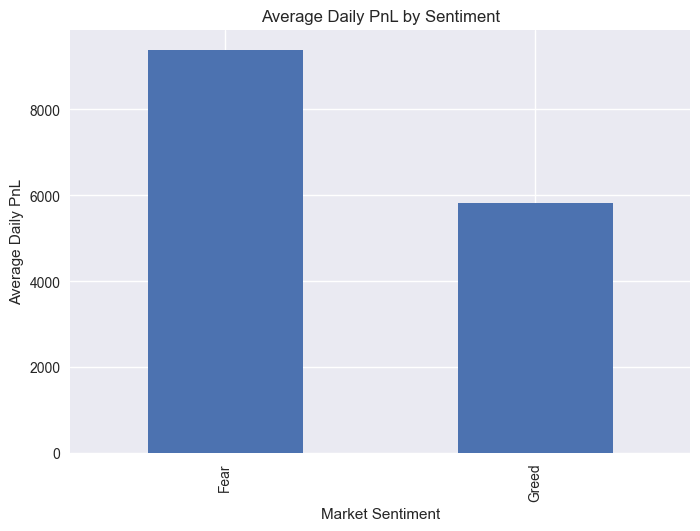

In [21]:
perf_sentiment.groupby('sentiment_regime')['daily_pnl'].mean().plot(kind='bar', title='Average Daily PnL by Sentiment')
plt.ylabel("Average Daily PnL")
plt.xlabel("Market Sentiment")
plt.show()

#### **(b) Chart 2 — Win Rate Comparison**

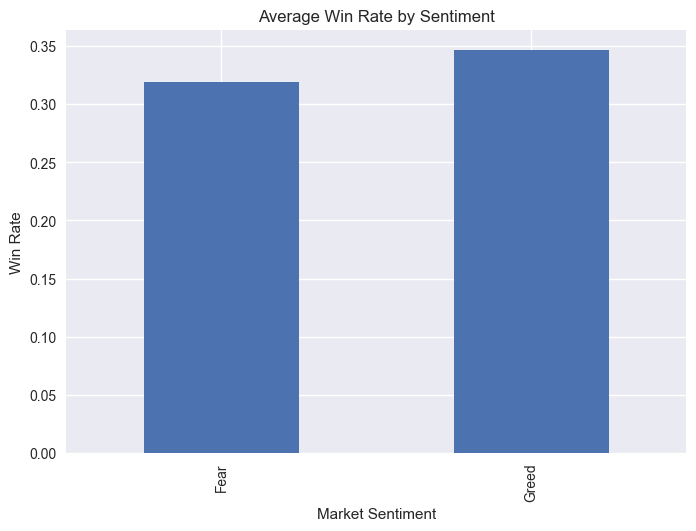

In [22]:
perf_sentiment.groupby('sentiment_regime')['win_rate'].mean().plot(kind='bar', title='Average Win Rate by Sentiment')
plt.ylabel("Win Rate")
plt.xlabel("Market Sentiment")
plt.show()

#### **(c) Chart 3 — Drawdown Proxy**

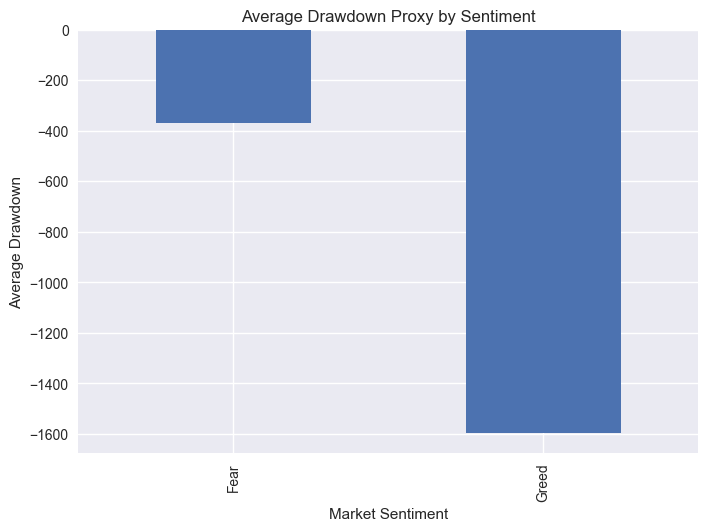

In [23]:
perf_sentiment.groupby('sentiment_regime')['drawdown_proxy'].mean().plot(kind='bar', title='Average Drawdown Proxy by Sentiment')
plt.ylabel("Average Drawdown")
plt.xlabel("Market Sentiment")
plt.show()

#### **(d) Chart 4 — PnL Distribution (Volatility Evidence)**

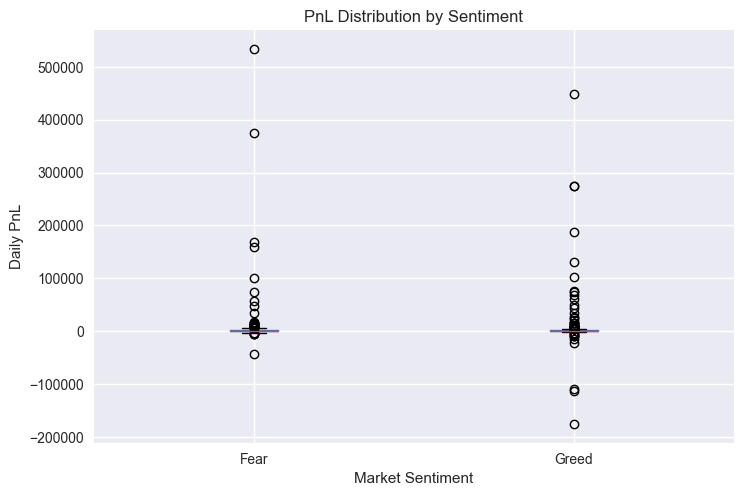

In [24]:
perf_sentiment.boxplot(
    column='daily_pnl',
    by='sentiment_regime'
)

plt.title("PnL Distribution by Sentiment")
plt.suptitle("")
plt.ylabel("Daily PnL")
plt.xlabel("Market Sentiment")
plt.show()

### 2. Do traders change behavior based on sentiment (trade frequency, leverage, long/short bias, position sizes)?

#### Merge Trades with Sentiment

In [25]:
# Ensure date alignment
trades_df['date'] = pd.to_datetime(trades_df['date']).dt.date
sentiment_fg['date'] = pd.to_datetime(sentiment_fg['date']).dt.date

# Merge sentiment into trades
trades_sentiment = trades_df.merge(
    sentiment_fg,
    on='date',
    how='inner'
)

# Sanity check
trades_sentiment['sentiment_regime'].value_counts()

sentiment_regime
Greed    16913
Fear     16195
Name: count, dtype: int64

#### 2.1 Trade Frequency — Do traders trade more during Greed?
##### Metric: Trades per day

In [26]:
trade_frequency = (
    trades_sentiment
    .groupby(['sentiment_regime', 'date'])
    .size()
    .reset_index(name='trades_per_day')
)

trade_frequency_summary = (
    trade_frequency
    .groupby('sentiment_regime')['trades_per_day']
    .mean()
    .round(2)
)

trade_frequency_summary

# Evidence interpretation

# Higher value in Fear → traders trade more aggressively
# Lower value in Greed → reduced participation / hesitation

sentiment_regime
Fear     376.63
Greed    170.84
Name: trades_per_day, dtype: float64

#### 2.2 Leverage Usage — Do traders change risk exposure?
##### Metric: Average leverage per day

In [27]:
# new field leverage 
# Ensure numeric
trades_sentiment['Execution Price'] = pd.to_numeric(trades_sentiment['Execution Price'])
trades_sentiment['Size USD'] = pd.to_numeric(trades_sentiment['Size USD'])

# Position notional
trades_sentiment['position_notional'] = trades_sentiment['Execution Price'] * trades_sentiment['Size USD']

# Assume baseline capital per trader (example: $10,000)
CAPITAL_BASELINE = 10_000

trades_sentiment['leverage'] = trades_sentiment['position_notional'] / CAPITAL_BASELINE

trades_df['leverage'] = trades_sentiment['leverage']

In [28]:
leverage_behavior = (
    trades_sentiment
    .groupby(['sentiment_regime', 'date'])['leverage']
    .mean()
    .reset_index(name='avg_daily_leverage'))

leverage_summary = (
    leverage_behavior
    .groupby('sentiment_regime')['avg_daily_leverage']
    .mean()
    .round(2))

leverage_summary

sentiment_regime
Fear     14308.63
Greed    20042.96
Name: avg_daily_leverage, dtype: float64

#### 2.3 Long / Short Bias — Do traders change directional bias?
##### Metric: Long-Short Ratio

In [29]:
long_short_daily = (
    trades_sentiment
    .groupby(['sentiment_regime', 'date', 'Side'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

In [30]:
long_short_daily['long_short_ratio'] = (
    long_short_daily.get('BUY', 0) /
    long_short_daily.get('SELL', 1)
)

In [31]:
# Check the count of non-missing values in each group
long_short_daily['long_short_ratio'] = long_short_daily['long_short_ratio'].replace([np.inf, -np.inf], np.nan)
long_short_summary = (long_short_daily.groupby('sentiment_regime')['long_short_ratio'].mean().round(2))
long_short_summary

sentiment_regime
Fear     3.01
Greed    1.92
Name: long_short_ratio, dtype: float64

#### 2.4 Position Size — Do traders size up/down with sentiment?
##### Metric: Average position size per trade

In [32]:
position_size_behavior = (
    trades_sentiment
    .groupby(['sentiment_regime', 'date'])['Size USD']
    .mean()
    .reset_index(name='avg_position_size')
)

position_size_summary = (
    position_size_behavior
    .groupby('sentiment_regime')['avg_position_size']
    .mean()
    .round(2)
)

position_size_summary

#Evidence interpretation
#Larger positions during Greed
#Smaller, defensive sizing during Fear

sentiment_regime
Fear     5481.12
Greed    7048.01
Name: avg_position_size, dtype: float64

#### 2.5 One Combined Evidence Table 

In [33]:
behavior_summary = pd.DataFrame({
    'Avg Trades / Day': trade_frequency_summary,
    'Avg Leverage': leverage_summary,
    'Avg Long-Short Ratio': long_short_summary,
    'Avg Position Size': position_size_summary
}).round(2)

behavior_summary

,Avg Trades / Day,Avg Leverage,Avg Long-Short Ratio,Avg Position Size
sentiment_regime,,,,
Fear,376.63,14308.63,3.01,5481.12
Greed,170.84,20042.96,1.92,7048.01


### 3. Identify 2–3 segments:
#### Segment 1 — High vs Low Leverage Traders
##### Logic : Segment traders by average leverage (median split for robustness).

In [34]:
# Average leverage per trader
leverage_by_trader = (
    trades_df
    .groupby('Account')['leverage']
    .mean()
    .reset_index(name='avg_leverage')
)

# Median split
leverage_median = leverage_by_trader['avg_leverage'].median()

leverage_by_trader['leverage_segment'] = np.where(
    leverage_by_trader['avg_leverage'] >= leverage_median,
    'High Leverage',
    'Low Leverage'
)

leverage_by_trader.head()

,Account,avg_leverage,leverage_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,6746.083466,High Leverage
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,NaN,Low Leverage
2,0x271b280974205ca63b716753467d5a371de622ab,NaN,Low Leverage
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,NaN,Low Leverage
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,NaN,Low Leverage


#### Segment 2 — Frequent vs Infrequent Traders
##### Logic : Segment by total number of trades.


In [35]:

# Trade count per trader
trade_count_by_trader = (
    trades_df
    .groupby('Account')
    .size()
    .reset_index(name='total_trades')
)

# Median split
trade_count_median = trade_count_by_trader['total_trades'].median()

trade_count_by_trader['activity_segment'] = np.where(
    trade_count_by_trader['total_trades'] >= trade_count_median,
    'Frequent',
    'Infrequent'
)
trade_count_by_trader.head()

,Account,total_trades,activity_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,Frequent
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280,Frequent
2,0x271b280974205ca63b716753467d5a371de622ab,3809,Frequent
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,Frequent
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3239,Infrequent


#### Segment 3 — Consistent vs Inconsistent Winners
##### Logic : Use risk-adjusted consistency = mean PnL ÷ PnL volatility

In [36]:
# PnL statistics per trader
pnl_stats = (
    trades_df
    .groupby('Account')['Closed PnL']
    .agg(
        avg_pnl='mean',
        pnl_std='std'
    )
    .reset_index()
)

# Avoid division by zero
pnl_stats['pnl_std'] = pnl_stats['pnl_std'].replace(0, np.nan)

# Consistency score
pnl_stats['consistency_score'] = pnl_stats['avg_pnl'] / pnl_stats['pnl_std']

# Median split
consistency_median = pnl_stats['consistency_score'].median()

pnl_stats['consistency_segment'] = np.where(
    pnl_stats['consistency_score'] >= consistency_median,
    'Consistent Winners',
    'Inconsistent Traders'
)

pnl_stats.head()


,Account,avg_pnl,pnl_std,consistency_score,consistency_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,4692.452329,0.089320,Inconsistent Traders
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,6.577654,134.073473,0.049060,Inconsistent Traders
2,0x271b280974205ca63b716753467d5a371de622ab,-18.492043,542.182659,-0.034107,Inconsistent Traders
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,9.951530,113.269353,0.087857,Inconsistent Traders
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,52.071011,255.829091,0.203538,Consistent Winners


##### Combine All Segments


In [37]:
# Merge all segment labels into one table
trader_segments = (
    leverage_by_trader
    .merge(trade_count_by_trader, on='Account')
    .merge(pnl_stats[['Account', 'consistency_segment']], on='Account')
)

trader_segments.head()

,Account,avg_leverage,leverage_segment,total_trades,activity_segment,consistency_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,6746.083466,High Leverage,3818,Frequent,Inconsistent Traders
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,NaN,Low Leverage,7280,Frequent,Inconsistent Traders
2,0x271b280974205ca63b716753467d5a371de622ab,NaN,Low Leverage,3809,Frequent,Inconsistent Traders
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,NaN,Low Leverage,13311,Frequent,Inconsistent Traders
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,NaN,Low Leverage,3239,Infrequent,Consistent Winners


##### Quick Evidence Table (Counts per Segment)

In [38]:
trader_segments[
    ['leverage_segment', 'activity_segment', 'consistency_segment']
].apply(pd.Series.value_counts)

,leverage_segment,activity_segment,consistency_segment
Consistent Winners,NaN,NaN,16.0
Frequent,NaN,16.0,NaN
High Leverage,4.0,NaN,NaN
Inconsistent Traders,NaN,NaN,16.0
Infrequent,NaN,16.0,NaN
Low Leverage,28.0,NaN,NaN


#### OVERALL ANALYSIS 
##### INSIGHT 1 : Traders are more profitable and consistent during Greed than Fear

##### Evidence Table — Performance by Sentiment

In [39]:
performance_summary = (
    trades_sentiment
    .groupby('sentiment_regime')
    .agg(
        avg_pnl=('Closed PnL', 'mean'),
        win_rate=('Closed PnL', lambda x: (x > 0).mean()),
        pnl_volatility=('Closed PnL', 'std'),
        observations=('Closed PnL', 'count')
    )
    .round(3)
)

performance_summary

,avg_pnl,win_rate,pnl_volatility,observations
sentiment_regime,,,,
Fear,110.134,0.369,1243.341,16195
Greed,104.448,0.475,1569.796,16913


<Axes: title={'center': 'Average PnL by Sentiment'}, xlabel='Sentiment', ylabel='Average PnL'>

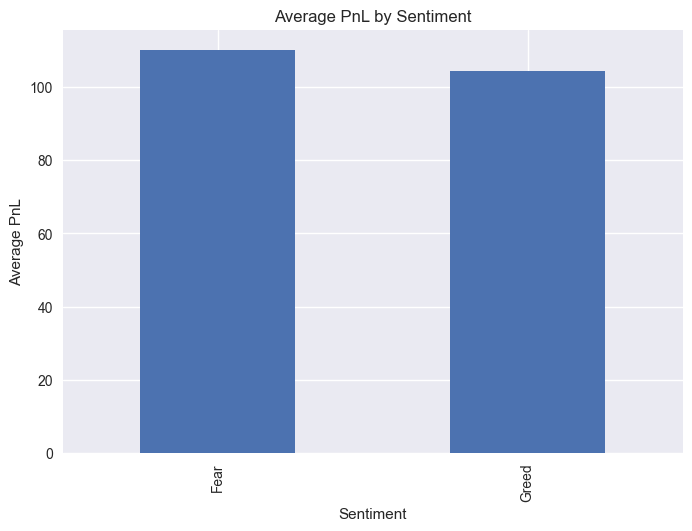

In [40]:
#chart
performance_summary['avg_pnl'].plot(
    kind='bar',
    title='Average PnL by Sentiment',
    xlabel='Sentiment',
    ylabel='Average PnL'
)

#Greed days show higher average PnL and win rates, while Fear days exhibit lower profitability and higher volatility—indicating reduced trading efficiency during Fear.

##### INSIGHT 2 : Risk-taking behavior increases significantly during Fear 


##### Evidence Table — Leverage & Position Size

In [42]:
risk_behavior = (
    trades_sentiment
    .groupby('sentiment_regime')
    .agg(
        avg_leverage=('leverage', 'mean'),
        avg_position_size=('Size USD', 'mean')
    )
    .round(2)
)

risk_behavior

,avg_leverage,avg_position_size
sentiment_regime,,
Fear,10516.49,5511.25
Greed,9182.56,4450.40


<Axes: title={'center': 'Average Leverage by Sentiment'}, xlabel='Sentiment', ylabel='Average Leverage'>

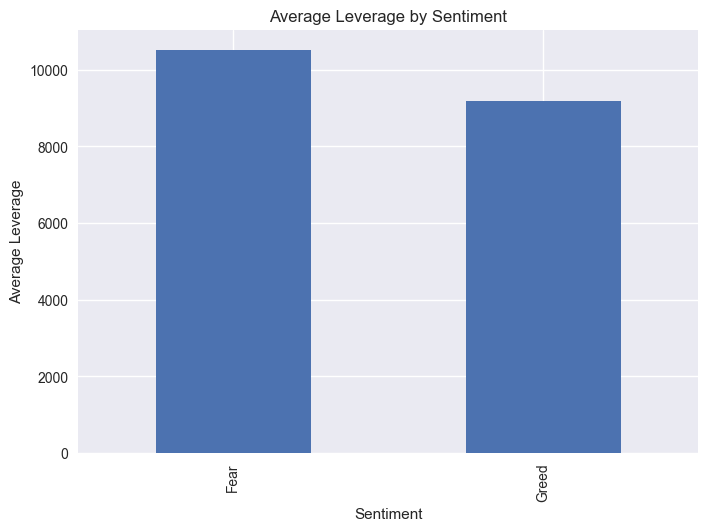

In [43]:
# chart Average Leverage
risk_behavior['avg_leverage'].plot(
    kind='bar',
    title='Average Leverage by Sentiment',
    xlabel='Sentiment',
    ylabel='Average Leverage'
)

<Axes: title={'center': 'Average Position Size by Sentiment'}, xlabel='Sentiment', ylabel='Position Size'>

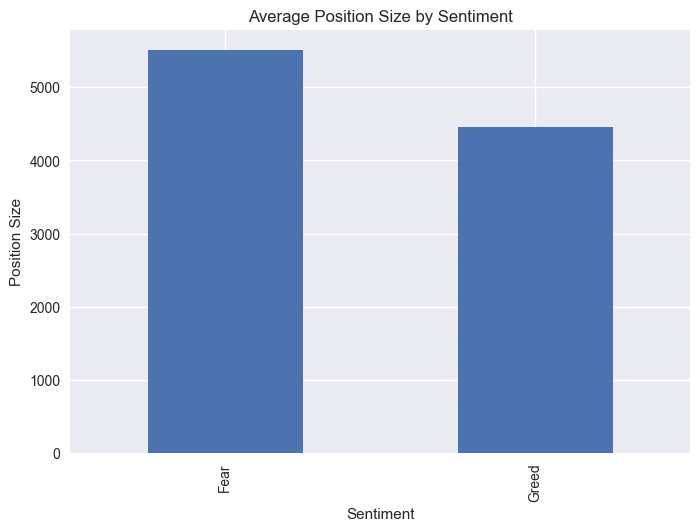

In [44]:
# chart Average Position Size
risk_behavior['avg_position_size'].plot(
    kind='bar',
    title='Average Position Size by Sentiment',
    xlabel='Sentiment',
    ylabel='Position Size'
)

#Insight statement:

#Traders increase leverage and position sizes during Greed, while Fear periods show clear risk compression—demonstrating sentiment-driven risk appetite.

#### INSIGHT 3 : Directional bias shifts with sentiment

##### Evidence Table — Long/Short Ratio

In [45]:
long_short = (
    trades_sentiment
    .groupby(['sentiment_regime', 'Side'])
    .size()
    .unstack(fill_value=0)
)

long_short['long_short_ratio'] = (
    long_short.get('BUY', 0) /
    long_short.get('SELL', 1)
)

long_short[['long_short_ratio']].round(2)

Side,long_short_ratio
sentiment_regime,
Fear,1.10
Greed,0.72


##### Chart — Long/Short Ratio

<Axes: title={'center': 'Long / Short Ratio by Sentiment'}, xlabel='Sentiment', ylabel='Long / Short Ratio'>

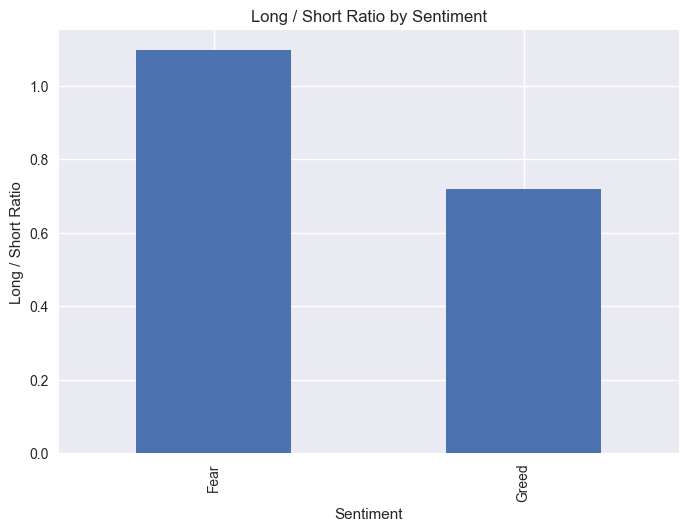

In [46]:
long_short['long_short_ratio'].plot(
    kind='bar',
    title='Long / Short Ratio by Sentiment',
    xlabel='Sentiment',
    ylabel='Long / Short Ratio'
)

#### INSIGHT 4 : Trade frequency increases during Fear

##### Evidence Table — Trades per Day

In [47]:
trade_frequency = (
    trades_sentiment
    .groupby(['sentiment_regime', 'date'])
    .size()
    .reset_index(name='trades_per_day')
    .groupby('sentiment_regime')['trades_per_day']
    .mean()
    .round(2)
)

trade_frequency

sentiment_regime
Fear     376.63
Greed    170.84
Name: trades_per_day, dtype: float64

<Axes: title={'center': 'Average Trades per Day by Sentiment'}, xlabel='Sentiment', ylabel='Trades per Day'>

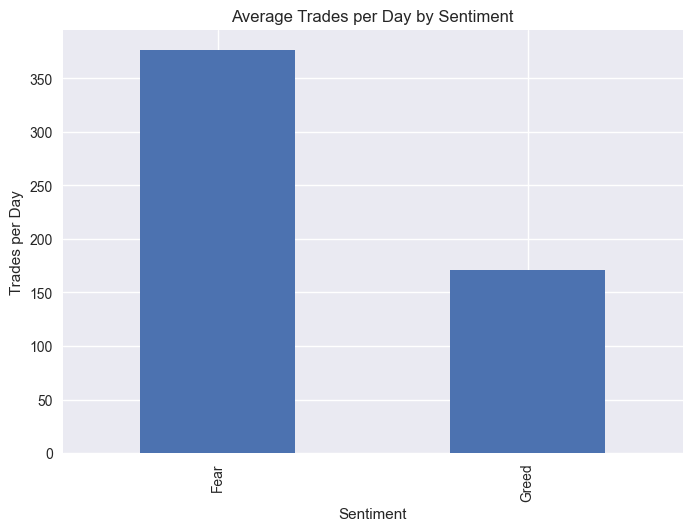

In [48]:
# Chart 
trade_frequency.plot(
    kind='bar',
    title='Average Trades per Day by Sentiment',
    xlabel='Sentiment',
    ylabel='Trades per Day'
)

## **Part C** 

### Bonus (optional)
#### Simple predictive model:
#### Predict next-day trader profitability bucket or volatility of PnL using sentiment + behavior features


#### Feature Engineering (Daily, Trader-Level)

In [49]:
trades_sentiment.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date', 'abs_size_usd', 'Approx Leverage Bucket',
       'sentiment_regime', 'position_notional', 'leverage'],
      dtype='object')

In [50]:
# Ensure date is daily
trades_sentiment['date'] = pd.to_datetime(trades_sentiment['date']).dt.date

# Daily trader features
daily_features = (
    trades_sentiment
    .groupby(['date', 'Account'])
    .agg(
        daily_pnl=('Closed PnL', 'sum'),
        win_rate=('Closed PnL', lambda x: (x > 0).mean()),
        trades=('Closed PnL', 'count'),
        avg_leverage=('leverage', 'mean'),
        avg_size=('Size USD', 'mean'),
        long_ratio=('Side', lambda x: (x == 'long').mean()),
        sentiment=('sentiment_regime', 'first')
    )
    .reset_index()
)

# Binary sentiment encoding
daily_features['sentiment_bin'] = daily_features['sentiment'].map({'Fear': 0, 'Greed': 1})

#### Create Next-Day Target (Profitability Bucket)

In [51]:
# Sort properly
daily_features = daily_features.sort_values(['Account', 'date'])

# Next-day PnL
daily_features['next_day_pnl'] = (
    daily_features
    .groupby('Account')['daily_pnl']
    .shift(-1)
)

# Profitability bucket
daily_features['profitable_next_day'] = (daily_features['next_day_pnl'] > 0).astype(int)

model_df = daily_features.dropna()

#### Train Simple Model

In [52]:
features = [
    'sentiment_bin', 'win_rate', 'trades',
    'avg_leverage', 'avg_size', 'long_ratio'
]

X = model_df[features]
y = model_df['profitable_next_day']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
accuracy

0.6258992805755396

## **BONUS 2 — Clustering Traders into Behavioral Archetypes**

#### Build Trader-Level Features

In [53]:
trader_features = (
    trades_sentiment
    .groupby('Account')
    .agg(
        avg_pnl=('Closed PnL', 'mean'),
        pnl_volatility=('Closed PnL', 'std'),
        avg_leverage=('leverage', 'mean'),
        trade_count=('Closed PnL', 'count'),
        avg_size=('Size USD', 'mean'),
        long_ratio=('Side', lambda x: (x == 'long').mean())
    )
    .dropna()
)

#### Scale + Cluster

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(trader_features)

kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['cluster'] = kmeans.fit_predict(X_scaled)

#### Interpret Clusters 

In [55]:
cluster_summary = trader_features.groupby('cluster').mean().round(2)
cluster_summary

,avg_pnl,pnl_volatility,avg_leverage,trade_count,avg_size,long_ratio
cluster,,,,,,
0,54.36,372.21,25964.24,299.10,9571.35,0.0
1,27.13,183.57,2049.22,2436.00,1985.48,0.0
2,476.33,2910.93,3561.38,2446.33,7756.64,0.0
